# Report content
1. problem statement
2. factors of influence
3. data preprocessing
4. modelling and evaluation
5. feature importance
6. conclusion and discussion

# 1. problem statement
Making prediction of cement strength and identifying most important factors of influence for it.

Using this information to give advice on how to stabilize cement quality and save costs.

# 2. factors of influence
Given data:
- Chemical composition X-ray fluorescense (XRF) measurements for the oxides (cao, ...)
- Mineralogical composition X-ray diffraction (XRD) measurements for the minerals (alite, ...)
- Powder fineness measurements (Blaine and sieves)
- Compressive strength measurements after 1, 3, 7, and 28 days

Ungiven data:
- Production process data

In [17]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from joblib import dump, load

%matplotlib inline

In [18]:
from model import select_model, train_test_split_by_date, get_top_features, voting_feature
from preprocess import remove_anomalies_by_isolation_forest, InterpolateMissingValue, Preprocessor
from plots import display_shap_plot

In [19]:
raw_data_path = "./data/raw/cement_strength_data.csv"
preprocessed_data_path = "./data/preprocessed"
ready_data_path = "./data/ready"
removed_collinearity_vif_data_path = "removed_collinearity_vif"
removed_collinearity_pca_data_path = "removed_collinearity_pca"
direct_train_data_path = "direct_train"
interpolated_by_date_file_name = "1_interpolated_by_date.joblib"
outlier_removed_with_isolation_forest_file_name = "2_outlier_removed_with_isolation_forest.joblib"
removed_collinearity_vif_file_name = "3_removed_collinearity_vif.joblib"
elasticnet_file_name = "elasticnet.joblib"
svm_file_name = "svm.joblib"
rf_file_name = "rf.joblib"
gbm_file_name = "gbm.joblib"


In [20]:
strength_columns = ["strength_1d", "strength_3d", "strength_7d", "strength_28d"]
CEMENT_TYPES = ["Type I-II", "Type III"]

In [21]:
TEST_SIZE = 0.2
CROSS_FOLDS = 5
VIF_THRESHOLD = 50
RANSOM_SEED = 0
TRAIN_TEST_DATE_THRESHOLD = "2017-01-01"
SCORING_METRICS = ["neg_mean_squared_error", "r2"]

In [22]:
df = pd.read_csv(raw_data_path)

In [23]:
df.describe()

,cao,sio2,al2o3,fe2o3,loi,so3,gypsum,calcite,alite,belite,aluminate,ferrite,free_lime,blaine,sieve_32um,sieve_45um,strength_1d,strength_3d,strength_7d,strength_28d
count,2595.000000,2595.000000,2595.000000,2595.000000,2612.000000,2595.000000,2576.00000,2583.000000,2576.000000,2576.000000,2576.000000,2576.000000,2588.000000,2613.000000,2613.000000,2612.000000,2612.000000,2612.000000,2611.000000,2611.000000
mean,62.297851,19.442634,4.685505,3.285897,2.768208,2.932758,2.66058,2.096901,58.162257,15.126956,4.287264,11.872531,0.815320,420.376196,4.323823,2.565291,17.468157,28.731868,34.535649,43.707200
std,0.578923,0.275175,0.167878,0.139716,0.292546,0.224402,0.78460,0.635508,2.832429,2.649767,0.430807,0.564229,0.196175,79.281684,2.075662,1.407401,3.662967,3.462995,3.077049,2.822397
min,60.740000,18.540000,3.540000,2.940000,1.100000,1.740000,0.23000,0.040000,48.570000,8.150000,3.160000,10.290000,0.290000,342.000000,0.200000,0.100000,11.970000,21.150000,26.840000,34.280000
25%,61.920000,19.270000,4.580000,3.180000,2.597500,2.760000,2.22000,1.591755,56.337500,13.279700,3.990000,11.470000,0.690000,375.000000,3.240000,1.640000,15.200000,26.427500,32.350000,41.740000
50%,62.290000,19.440000,4.690000,3.260000,2.760000,2.911750,2.81000,2.140000,58.210000,15.010000,4.290000,11.840000,0.810000,382.000000,4.800000,2.575000,15.960000,27.680000,33.930000,43.360000
75%,62.630000,19.620000,4.790000,3.370000,2.960000,3.060000,3.21000,2.560000,60.140900,16.782500,4.540000,12.230000,0.940000,395.000000,5.710000,3.480000,17.172500,29.872500,36.100000,45.475000
max,66.449900,20.910000,5.360000,4.050000,3.780000,3.640000,4.60000,4.110000,66.720000,24.920000,6.450000,14.750000,2.250000,613.000000,11.130000,8.340000,31.460000,40.130000,46.420000,55.070000


In [24]:
df.shape

(2613, 22)

# 3. data preprocessing


### convert date string to datetime type

In [25]:
df.loc[:, "sample_date"] = pd.to_datetime(df.sample_date)

## 3.1 test difference of strength distribution between type I-II and type III
Assumptions:
- T test: observations are normally distributed.
- Mann Whitney U Test: observations should be independent.

Method and result:
- With T test and U test, there is significant difference of strength distribution between type I-II and type III.

Other tests suitable for comparison of two time series data would be better.
- data are not normally distributed.
- data are denpendent within groups.

In [26]:
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from scipy.stats import normaltest

In [27]:
_, pvalues = normaltest(df.drop(["sample_date", "material_name"], axis=1), axis=0)
df.columns.drop(["sample_date", "material_name"])[pvalues > 0.05].tolist()

[]

In [28]:
mask = df.loc[:, strength_columns].isnull().any(axis=1)
print(sum(mask))
df_remove_null_strength = df.loc[~mask, :]
df_type12 = df_remove_null_strength.loc[df_remove_null_strength.material_name == CEMENT_TYPES[0], :]
df_type3 = df_remove_null_strength.loc[df_remove_null_strength.material_name == CEMENT_TYPES[1], :]

6


In [29]:
p_values = {}
for strength_column in strength_columns:
    _, p = ttest_ind(df_type12.loc[:, strength_column], df_type3.loc[:, strength_column])
    p_values["t_test_" + strength_column] = p
    _, p = mannwhitneyu(df_type12.loc[:, strength_column], df_type3.loc[:, strength_column])
    p_values["u_test_" + strength_column] = p
print(p_values)

{'t_test_strength_1d': 0.0, 'u_test_strength_1d': 1.446590053865806e-291, 't_test_strength_3d': 0.0, 'u_test_strength_3d': 5.326940098493014e-288, 't_test_strength_7d': 0.0, 'u_test_strength_7d': 5.339633470289083e-267, 't_test_strength_28d': 2.241401378344463e-293, 'u_test_strength_28d': 1.294204579512005e-200}


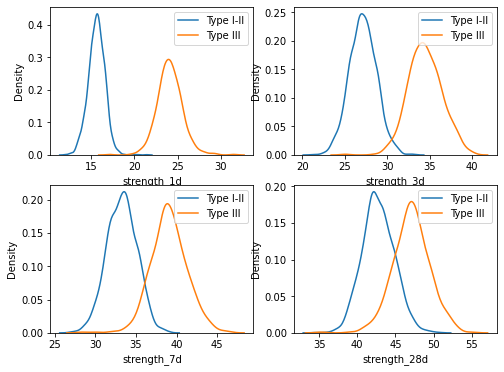

In [30]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8,6))
axes = [ax1, ax2, ax3, ax4]
for idx, column in enumerate(strength_columns):
    sns.kdeplot(df_type12.loc[:, column], label=CEMENT_TYPES[0], ax=axes[idx])
    sns.kdeplot(df_type3.loc[:, column], label=CEMENT_TYPES[1], ax=axes[idx])
    axes[idx].legend()

### split data with different cement types

In [31]:
df_type12 = df.loc[df.material_name == CEMENT_TYPES[0], :].drop("material_name", axis=1)
df_type3 = df.loc[df.material_name == CEMENT_TYPES[1], :].drop("material_name", axis=1)

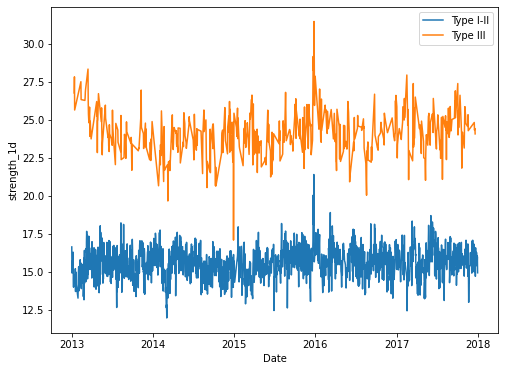

In [32]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(df_type12.sample_date, df_type12.loc[:, strength_columns[0]], label=CEMENT_TYPES[0])
ax.plot(df_type3.sample_date, df_type3.loc[:, strength_columns[0]], label=CEMENT_TYPES[1])
ax.set_xlabel('Date')
ax.set_ylabel(strength_columns[0])
plt.legend()
plt.show()

## 3.2 dealing with missing data
1. **interpolation**
2. remove
3. KNN
4. mean, median, mode

Assumption
- the production is a continuous process. The adjacent observations will be like the missing data.

Method and result
- Missing data percentage is less than 2%. They are interpolated by adjacent data considering sample date.



In [33]:
preprocessor = Preprocessor(df, [])
preprocessor.run()

In [34]:
df_removed_missing = InterpolateMissingValue()(preprocessor.cleaned_df)

In [35]:
dump(df_removed_missing, os.path.join(preprocessed_data_path, interpolated_by_date_file_name))

['./data/preprocessed\\1_interpolated_by_date.joblib']

## 3.3 train test split

In [36]:
feature_columns = df_removed_missing.columns.drop(strength_columns)

train_X, test_X, train_Y, test_Y = train_test_split_by_date(
    df_removed_missing.loc[:, feature_columns],
    df_removed_missing.loc[:, strength_columns],
    TRAIN_TEST_DATE_THRESHOLD
)

Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.


## 3.4 dealing with outliers
1. statistical tests
2. **IsolationForest**
3. K-means

Method and result:
- IsolationForest is used. Data points with short tree paths will be considered as outliers, since they have possibly extreme feature values.
- Since the exact feature which causes the outlier is not clear, outliers are removed.
- outlier percentage: 11.6%

In [37]:
from sklearn.ensemble import IsolationForest

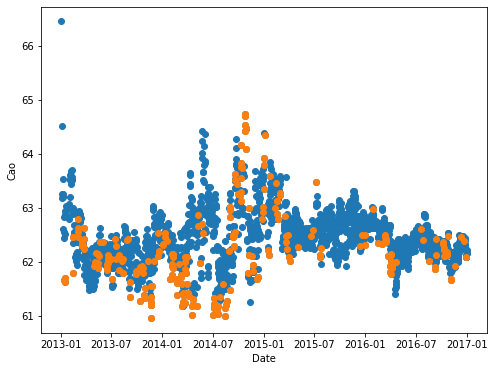

In [39]:
detector = IsolationForest(random_state=RANSOM_SEED)
result = detector.fit_predict(train_X)
outliers = train_X.loc[result==-1, :]
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(train_X.index, train_X.cao)
ax.scatter(outliers.index, outliers.cao)
ax.set_xlabel('Date')
ax.set_ylabel('Cao')
plt.show()

In [54]:
train_X_no_outlier, train_Y_no_outlier = remove_anomalies_by_isolation_forest(train_X, train_Y)

In [55]:
# outlier percentage
100 - train_X_no_outlier.shape[0] / train_X.shape[0] * 100

11.599045346062056

In [56]:
dump(pd.concat([train_X_no_outlier, train_Y_no_outlier]), os.path.join(preprocessed_data_path, outlier_removed_with_isolation_forest_file_name))

['./data/preprocessed\\2_outlier_removed_with_isolation_forest.joblib']

# 4. modelling and evaluation

Models:
1. linear regression with elastic net
2. svm
3. forest
4. GBM

Method and result:

Without outlier
1. With VIF threshold as 50, 5 features are selected: ``sieve_32um``, ``sieve_45um``, ``free_lime``, ``calcite``, ``gypsum``.
- best model is random forest, mse for test data is ``1.11``.

2. With PCA
- best model is elastic net, mse for test data is ``0.93``.

3. direct train
- best model is elastic net, mse for test data is ``0.82``.

With outlier
1. With VIF threshold as 50, 5 features are selected: ``sieve_32um``, ``sieve_45um``, ``free_lime``, ``calcite``, ``gypsum``.
- best model is random forest, mse for test data is ``1.60``.

2. With PCA
- best model is gbm, mse for test data is ``0.98``.

3. direct train
- best model is svm, mse for test data is ``0.88``.

In [57]:
all_scores = []
best_model_names = []

## 4.1 remove multicollinearity, remove outlier, train
1. VIF
2. PCA

In [58]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(df):
    vif = pd.DataFrame()
    vif["variables"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

    return(vif)

In [59]:
vif_result = calc_vif(train_X_no_outlier)
selected_features = vif_result.loc[vif_result.VIF < VIF_THRESHOLD, "variables"].to_list()
selected_features

['gypsum', 'calcite', 'free_lime', 'sieve_32um', 'sieve_45um']

In [60]:
selected_train_X = train_X_no_outlier.loc[:, selected_features]
selected_train_X[["is_train"]] = 1
selected_test_X = test_X.loc[:, selected_features]
selected_test_X[["is_train"]] = 0

X_Y = pd.concat([selected_train_X.append(selected_test_X), train_Y_no_outlier.append(test_Y)], axis=1)
dump(X_Y, os.path.join(ready_data_path, removed_collinearity_vif_data_path, removed_collinearity_vif_file_name))


['./data/ready\\removed_collinearity_vif\\3_removed_collinearity_vif.joblib']

In [61]:
scores = select_model(
    train_X_no_outlier.loc[:, selected_features],
    train_Y_no_outlier.loc[:, strength_columns[0]],
    test_X.loc[:, selected_features],
    test_Y.loc[:, strength_columns[0]],
    os.path.join(ready_data_path, removed_collinearity_vif_data_path),
    standardize=True,
    pca=False
)
best_model_names.append(scores[0])
all_scores.extend(scores)

[LibSVM][LightGBM] [Warning] min_gain_to_split is set=0.3, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3


### training with PCA

In [62]:
scores = select_model(
    train_X_no_outlier,
    train_Y_no_outlier.loc[:, strength_columns[0]],
    test_X,
    test_Y.loc[:, strength_columns[0]],
    os.path.join(ready_data_path, removed_collinearity_pca_data_path),
    standardize=True,
    pca=True
)
best_model_names.append(scores[0])
all_scores.extend(scores)

[LibSVM][LightGBM] [Warning] min_gain_to_split is set=0.4, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4


## 4.2 remove outlier, train

In [63]:
scores = select_model(
    train_X_no_outlier,
    train_Y_no_outlier.loc[:, strength_columns[0]],
    test_X,
    test_Y.loc[:, strength_columns[0]],
    os.path.join(ready_data_path, direct_train_data_path),
    standardize=True,
    pca=False
)
best_model_names.append(scores[0])
all_scores.extend(scores)

[LibSVM][LightGBM] [Warning] min_gain_to_split is set=0.4, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4


## 4.3 remove multicollinearity, train

In [64]:
vif_result = calc_vif(train_X)
selected_features = vif_result.loc[vif_result.VIF < VIF_THRESHOLD, "variables"].to_list()
selected_features

['gypsum', 'calcite', 'free_lime', 'sieve_32um', 'sieve_45um']

In [65]:
scores = select_model(
    train_X.loc[:, selected_features],
    train_Y.loc[:, strength_columns[0]],
    test_X.loc[:, selected_features],
    test_Y.loc[:, strength_columns[0]],
    os.path.join(preprocessed_data_path, removed_collinearity_vif_data_path),
    standardize=True,
    pca=False
)
best_model_names.append(scores[0])
all_scores.extend(scores)

[LibSVM][LightGBM] [Warning] min_gain_to_split is set=0.3, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3


### PCA

In [66]:
scores = select_model(
    train_X,
    train_Y.loc[:, strength_columns[0]],
    test_X,
    test_Y.loc[:, strength_columns[0]],
    os.path.join(preprocessed_data_path, removed_collinearity_pca_data_path),
    standardize=True,
    pca=True
)
best_model_names.append(scores[0])
all_scores.extend(scores)

[LibSVM][LightGBM] [Warning] min_gain_to_split is set=0.3, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3


## 4.4 train

In [67]:
scores = select_model(
    train_X,
    train_Y.loc[:, strength_columns[0]],
    test_X,
    test_Y.loc[:, strength_columns[0]],
    os.path.join(preprocessed_data_path, direct_train_data_path),
    standardize=True,
    pca=False
)
best_model_names.append(scores[0])
all_scores.extend(scores)

[LibSVM][LightGBM] [Warning] min_gain_to_split is set=0.3, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3


## 4.5 result

In [113]:
best_model_name_df = []
for name, item in best_model_names:
    item.update({"name": name})
    best_model_name_df.append(item)
pd.DataFrame(best_model_name_df)

,test_mse,train_mse,name
0,-1.982918,-9.768663,./data/ready\removed_collinearity_vif\gbm.joblib
1,-0.937139,-10.315254,./data/ready\removed_collinearity_pca\elasticn...
2,-0.823279,-4.662929,./data/ready\direct_train\elasticnet.joblib
3,-1.734722,-1.941016,./data/preprocessed\removed_collinearity_vif\r...
4,-0.952929,-1.416585,./data/preprocessed\removed_collinearity_pca\g...
5,-0.872270,-1.006581,./data/preprocessed\direct_train\svm.joblib


In [124]:
from sklearn.metrics import r2_score
r2_score(test_Y.iloc[:, 0], load(best_model_names[2][0]).predict(test_X))

0.939832520883491

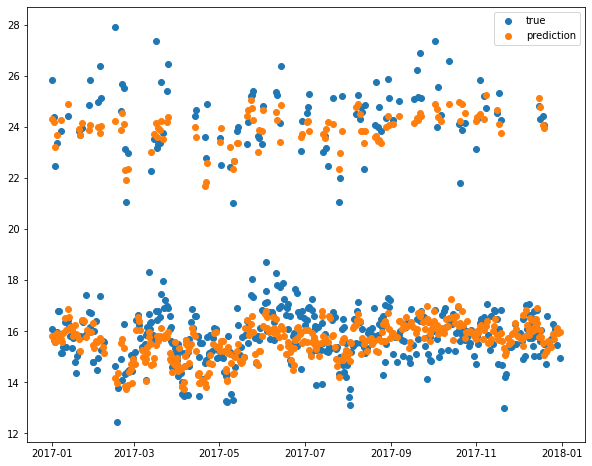

In [98]:
best_model_name = sorted(best_model_names, key=lambda x: x[1]["test_mse"], reverse=True)[0][0]
best_model = load(best_model_name)
fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(test_X.index, test_Y.strength_1d, label="true")
ax.scatter(test_X.index, best_model.predict(test_X), label="prediction")
plt.legend()
plt.show()

# 5. feature importance
1. filter based: statistical tests
2. hybrid: recursive feature elimination
3. model embedded: feature importance of models
4. others: permutation feature importance, SHAP, PDP

## 5.1 results from correlation and models

Method and result:
- Use spearman correlation and feature importance of models, top features by voting: ``sieve_32um``, ``is_type_IorII``, ``sieve_45um``, ``blaine``.

limits:
- non-monotonic relationship is not considered in spearman correlation
- selection of features in tree are based on impurity reduction and may not be optimal.

In [80]:
feature_importance = {}

In [81]:
correlation = df_removed_missing.corr(method='spearman').drop(strength_columns, axis=0).drop(feature_columns, axis=1)
for column in strength_columns:
    feature_importance["corr_"+column] = correlation.index[np.argsort(-np.abs(correlation.loc[:, column]), )[:5]].tolist()

In [82]:
for idx in [0, 2, 3, 5]:
    best_model_name = best_model_names[idx][0]
    best_model = load(best_model_name).named_steps["randomizedsearchcv"].best_estimator_
    if idx % 3 == 0:
        all_features = np.array(selected_features)
    else:
        all_features = train_X.columns.to_numpy()
    feature_importance[best_model_name] = get_top_features(best_model, all_features)

In [85]:
feature_importance_df = pd.DataFrame.from_dict(feature_importance)
feature_importance_df = feature_importance_df.drop(["corr_"+column for column in strength_columns[1:]], axis=1)
feature_importance_df

,corr_strength_1d,./data/ready\removed_collinearity_vif\gbm.joblib,./data/ready\direct_train\elasticnet.joblib,./data/preprocessed\removed_collinearity_vif\rf.joblib,./data/preprocessed\direct_train\svm.joblib
0,is_type_IorII,sieve_32um,is_type_IorII,sieve_32um,is_type_IorII
1,sieve_32um,gypsum,blaine,sieve_45um,blaine
2,sieve_45um,sieve_45um,belite,calcite,belite
3,blaine,calcite,sieve_32um,gypsum,sieve_32um
4,so3,free_lime,alite,free_lime,alite


In [84]:
top_features = voting_feature(feature_importance_df)
top_features

[('sieve_32um', 18),
 ('is_type_IorII', 15),
 ('sieve_45um', 10),
 ('blaine', 10),
 ('gypsum', 6),
 ('belite', 6),
 ('calcite', 5),
 ('free_lime', 2),
 ('alite', 2),
 ('so3', 1)]

## 5.2 SHAP plot

Method and result:
- Use SHAP. Top features are ``is_type_IorII``, ``blaine``, ``belite``, ``sieve_32um``.


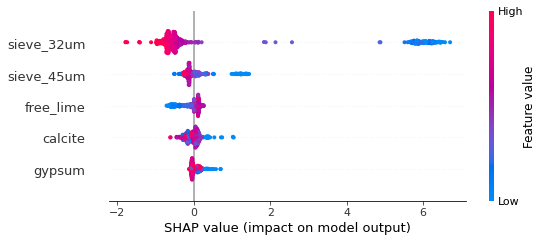

In [119]:
# random forest
display_shap_plot(best_model_names[0][0], train_X_no_outlier.loc[:, selected_features], test_X.loc[:, selected_features])

Permutation explainer: 521it [00:13,  8.89it/s]                         


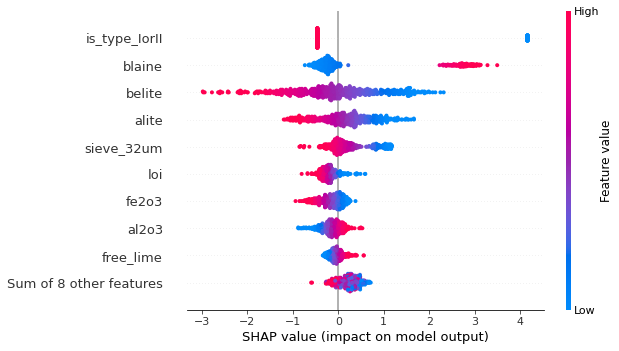

In [101]:
# elastic net
display_shap_plot(best_model_names[2][0], train_X_no_outlier, test_X)

Permutation explainer: 521it [12:35,  1.47s/it]


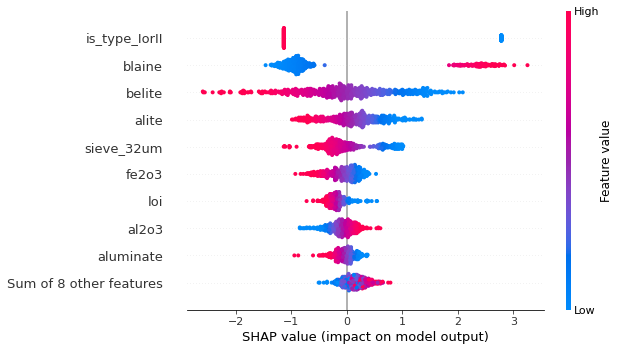

In [120]:
# svm
display_shap_plot(best_model_names[5][0], train_X, test_X)

## 5.3 ALE

In [34]:
from PyALE import ale

In [42]:
models = load("./data/ready/direct_train/elasticnet.joblib")
features = ["blaine", "belite", "sieve_32um"]

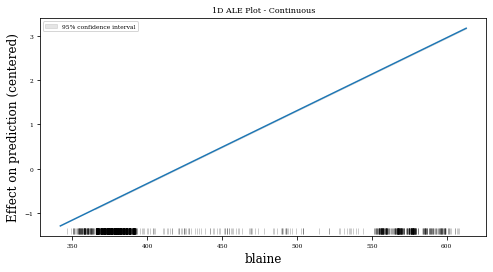

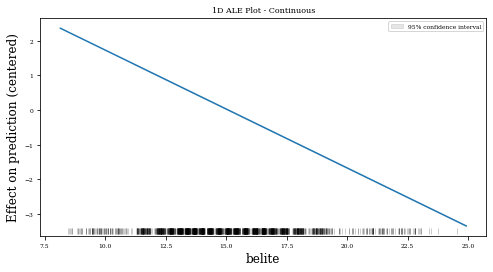

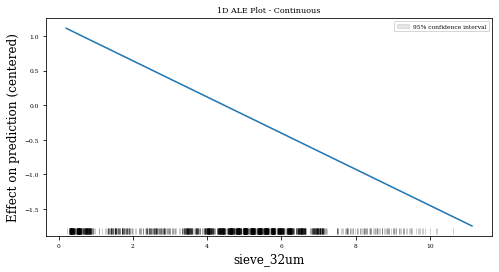

In [44]:
for feature in features:
    ale(
        X=train_X,
        model=models,
        feature=[feature],
        feature_type="continuous",
        include_CI=True,
        C=0.95,
    )

# 6. conclusion

1. Which factors influence cement strength?
- ``is_type_IorII``, ``blaine``, ``belite``, ``sieve_32um``.
- ``Type III`` has a large positive impact on the 1d strength prediction.
- A large value of ``blaine`` has a large positive impact on the 1d strength prediction.
- low level of ``sieve_32um`` and ``belite`` have positive impact on the 1d strength prediction.

2. With what accuracy can 1 day strength be predicted on the day of production?
- Removing outlier and use elastic net, mse for test data is ``0.82``, r2 is ``0.94``.

3. Improvements
- Outlier
- Model
- Data